## Multi-threading case

In [1]:
!pip3 install selenium==4.6.0
!pip3 install webdriver-manager==3.8.5
!pip3 install diagrams==0.23.1
!pip3 install retry==0.9.2
!pip3 install loguru==0.6.0

In [2]:
import os
import threading
import time

from selenium import webdriver
from selenium.webdriver.common.by import By

from webdriver_manager.chrome import ChromeDriverManager
from webdriver_manager.core.utils import ChromeType
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.chrome.service import Service

from IPython import display
from IPython.display import Image
from base64 import b64decode, urlsafe_b64decode, decodebytes

from retry import retry
from loguru import logger
from timeit import default_timer as timer
from datetime import timedelta

In [3]:
def saveBase64Image(img_data, filename):
    with open(f"src/{filename}", "wb") as fh:
        fh.write(b64decode(img_data))

In [4]:
logger.add("file_{time}.log", level='DEBUG')

1

In [5]:
chrome_service = Service(ChromeDriverManager().install())
logger.info("Install chrome driver")

2022-12-11 01:38:52.286 | INFO     | __main__:<module>:2 - Install chrome driver


In [6]:
# Get environment variables
IS_GITHUB_ACTION = os.getenv('IS_GITHUB_ACTION')
logger.info("Set github action env")

2022-12-11 01:38:52.292 | INFO     | __main__:<module>:3 - Set github action env


In [7]:
chrome_options = Options()
if IS_GITHUB_ACTION:
    options = [
        "--headless",
        "--disable-gpu",
        "--window-size=1920,1080",
        "--ignore-certificate-errors",
        "--disable-extensions",
        "--no-sandbox",
        "--disable-dev-shm-usage"
    ]
    user_agent = 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/60.0.3112.50 Safari/537.36'    
    chrome_options.add_argument('user-agent={0}'.format(user_agent))
    for option in options:
        chrome_options.add_argument(option)

logger.info("Set chrome driver options")

2022-12-11 01:38:52.298 | INFO     | __main__:<module>:17 - Set chrome driver options


In [8]:
logger.info("Run chrome driver")
browser = webdriver.Chrome(service=chrome_service, options=chrome_options)
browser.set_window_size(1920, 1080)
browser.get('https://www.gotokyo.org/kr/destinations/index.html')
logger.debug("Load main page done url {url}", url='https://www.gotokyo.org/kr/destinations/index.html')

2022-12-11 01:38:52.304 | INFO     | __main__:<module>:1 - Run chrome driver
2022-12-11 01:38:56.477 | DEBUG    | __main__:<module>:5 - Load main page done url https://www.gotokyo.org/kr/destinations/index.html


2022-12-11 01:38:56.486 | INFO     | __main__:<module>:1 - Crawl place list
2022-12-11 01:38:56.505 | DEBUG    | __main__:<module>:3 - Place list len: 9


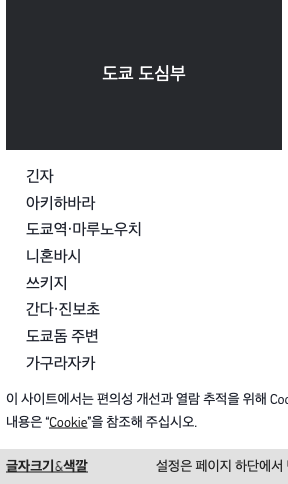

In [9]:
logger.info("Crawl place list")
placeList = browser.find_elements(By.CSS_SELECTOR, '#tmp_explore_tokyo > div > ul.mod_figure_list > li');
logger.debug("Place list len: {place_len}", place_len = len(placeList))
display.Image(b64decode(placeList[0].screenshot_as_base64))

# saveBase64Image(placeList[0].screenshot_as_base64, "test.png")

In [10]:
def getAreaListFromPlace(place):
    try:
        return [(area.text, area.get_attribute("href")) for area in place.find_elements(By.CSS_SELECTOR, "a + ul > li > a")]
    except Exception as e:
        logger.error("Cannot get place data, e: {err}", place=place, err=e)
    return []


In [11]:
logger.info("Crawl place's area data")
placeAndUrlList = [(place.find_element(By.TAG_NAME, 'a').text, 
                    place.find_element(By.TAG_NAME, 'a').get_attribute('href'),
                    getAreaListFromPlace(place)
                   ) for place in placeList]
logger.debug("Place's area data: {data}", data=placeAndUrlList)
# placeAndUrlList

2022-12-11 01:38:56.607 | INFO     | __main__:<module>:1 - Crawl place's area data
2022-12-11 01:38:58.119 | DEBUG    | __main__:<module>:6 - Place's area data: [('도쿄 도심부', 'https://www.gotokyo.org/kr/destinations/central-tokyo/index.html', [('긴자', 'https://www.gotokyo.org/kr/destinations/central-tokyo/ginza/index.html'), ('아키하바라', 'https://www.gotokyo.org/kr/destinations/central-tokyo/akihabara/index.html'), ('도쿄역・마루노우치', 'https://www.gotokyo.org/kr/destinations/central-tokyo/tokyo-station-and-marunouchi/index.html'), ('니혼바시', 'https://www.gotokyo.org/kr/destinations/central-tokyo/nihombashi/index.html'), ('쓰키지', 'https://www.gotokyo.org/kr/destinations/central-tokyo/tsukiji/index.html'), ('간다・진보초', 'https://www.gotokyo.org/kr/destinations/central-tokyo/kanda-and-jimbocho/index.html'), ('도쿄돔 주변', 'https://www.gotokyo.org/kr/destinations/central-tokyo/tokyo-dome-and-around/index.html'), ('가구라자카', 'https://www.gotokyo.org/kr/destinations/central-tokyo/kagurazaka/index.html'), ('아카사카', '

In [12]:
logger.info("Close place crawling browser")
browser.close()

2022-12-11 01:38:58.127 | INFO     | __main__:<module>:1 - Close place crawling browser


## Get area's detail info

In [20]:
def getSlideItems(slideItemList):
    logger.debug("Slider item list len {}", len(slideItemList))
    try:
        return [(slideItem.find_element(By.TAG_NAME, 'img').get_attribute('alt'), # tour content name
            slideItem.find_element(By.TAG_NAME, 'img').get_attribute('src'), # tour content img
            slideItem.find_element(By.TAG_NAME, 'a').get_attribute('href') # tour content detail link
            ) for slideItem in slideItemList]
    except Exception as e:
        logger.error("Slider item error {}", e)

In [21]:
@retry(Exception, tries=3, delay=2)
def getSlideList(browser):
    sliderCrawlResult = []
    try:
        logger.info("Remove banner to load slider list")
        browser.execute_script("document.querySelector('div.section_banner_top').remove();document.querySelector('div.left_block').remove();jQuery(window).scroll();")
        logger.info("Banner removed")
    except Exception as e:
        logger.error("Remove banner has an error {}", e)
    logger.info("Crawl slider items")
    sliderCrawlResult = [(
        slider.find_element(By.CSS_SELECTOR, 'div.slider_ttl > h2').text, #title
        getSlideItems([item for item in slider.find_elements(By.CSS_SELECTOR, 'div.slick_slide_item')]) #slider's items
        ) for slider in browser.find_elements(By.CSS_SELECTOR, 'div.section_slider_body')]
    logger.debug("Crawl slider items result {}", sliderCrawlResult)
    if sum([len(sliderItemList[1]) for sliderItemList in sliderCrawlResult]) <= 0:
        logger.info("Slider is empty, raise error");
        raise Exception('Data not found')
    return sliderCrawlResult
    
# getSlideList(browser)

In [22]:
@retry(Exception, tries=3, delay=2)
def initHeadlessBrowser():
    logger.info("Setup headless browser options")
    chrome_options = Options()
    options = [
        "--headless",
        "--disable-gpu",
        "--window-size=1920,1080",
        "--ignore-certificate-errors",
        "--disable-extensions",
        "--no-sandbox",
        "--disable-dev-shm-usage",
        "start-maximized",
        "disable-infobars"
    ]
    user_agent = 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/60.0.3112.50 Safari/537.36'    
    chrome_options.add_argument('user-agent={0}'.format(user_agent))
    for option in options:
        chrome_options.add_argument(option)
    browser = webdriver.Chrome(service=chrome_service, options=chrome_options)
    browser.set_window_size(1920, 1080)
    return browser

In [23]:
def resizeBrowserHeightAsContentFullHeight(browser):
    logger.info("Update browser's height same as content height")
    requireHeight = browser.execute_script('return document.body.parentNode.scrollHeight')
    logger.debug("Current content height {}", requireHeight)
    browser.set_window_size(1920, requireHeight)
    browser.execute_script("document.querySelector('div.section_banner_top.setheight').style.height = '464px';")
    logger.info("Manually set banner's height")
    time.sleep(2) # Because of pictures load time

In [24]:
def getAreaInfoProcess(areaName, url, queue=None, idx=None):
    logger.debug("Area crawling process start, url: {}", url)
    slidItemList = []
    try:
        browser = initHeadlessBrowser()
        logger.debug("Browser move to url: {}", url)
        browser.get(url)
        resizeBrowserHeightAsContentFullHeight(browser)
        saveBase64Image(browser.find_element(By.CSS_SELECTOR, "div.left_block").screenshot_as_base64, f'{areaName}.png')
        slidItemList = getSlideList(browser)
        logger.info("Get slider item done")
        if queue is not None:
            queue.put((idx, slidItemList))
    except Exception as e:
        logger.error('Cannot get area info data {}', e)
    finally:
        browser.close()
    logger.info("Area crawling browser closed")
    return slidItemList

In [25]:
start = timer()
getAreaInfoProcess('ginza', 'https://www.gotokyo.org/kr/destinations/central-tokyo/ginza/index.html')
end = timer()
logger.debug("Process take time {}", timedelta(seconds=end-start))

2022-12-11 01:46:56.360 | DEBUG    | __main__:getAreaInfoProcess:2 - Area crawling process start, url: https://www.gotokyo.org/kr/destinations/central-tokyo/ginza/index.html
2022-12-11 01:46:56.361 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-11 01:46:57.359 | DEBUG    | __main__:getAreaInfoProcess:6 - Browser move to url: https://www.gotokyo.org/kr/destinations/central-tokyo/ginza/index.html
2022-12-11 01:46:59.430 | INFO     | __main__:resizeBrowserHeightAsContentFullHeight:2 - Update browser's height same as content height
2022-12-11 01:46:59.443 | DEBUG    | __main__:resizeBrowserHeightAsContentFullHeight:4 - Current content height 5734
2022-12-11 01:46:59.551 | INFO     | __main__:resizeBrowserHeightAsContentFullHeight:7 - Manually set banner's height
2022-12-11 01:47:02.524 | INFO     | __main__:getSlideList:5 - Remove banner to load slider list
2022-12-11 01:47:02.538 | INFO     | __main__:getSlideList:7 - Banner removed
2022-12-11 01:47:0

2022-12-11 01:47:05.644 | INFO     | __main__:getAreaInfoProcess:11 - Get slider item done
2022-12-11 01:47:05.699 | INFO     | __main__:getAreaInfoProcess:18 - Area crawling browser closed
2022-12-11 01:47:05.701 | DEBUG    | __main__:<module>:4 - Process take time 0:00:09.338767


## Single thread, Single process

In [ ]:
start = timer()
areaCrawlingResult = []
for place in placeAndUrlList:
    logger.debug("place: {} len: {}", place[0], len(place[2]))
    for area in place[2]:
        logger.debug("area: {} url: {}", area[0], area[1])
        areaCrawlingResult.append(getAreaInfoProcess(area[0], area[1]))
end = timer()
logger.debug("Process take time {}", timedelta(seconds=end-start))

```
2022-12-10 22:26:21.084 | DEBUG    | __main__:<module>:9 - Process take time 0:12:11.764783
```

In [ ]:
areaCrawlingResult

In [ ]:
import json
with open("areaCrawlingResult.json", 'w') as outfile:
    json.dump(areaCrawlingResult, outfile)
    
with open("placeAndUrlList.json", 'w') as outfile:
    json.dump(placeAndUrlList, outfile)

In [ ]:
areaCrawlingResult[0][0]

## Single process, Multi-threading

In [15]:
from queue import Queue

In [26]:
start = timer()
areaCrawlingResult = []
queue = Queue()
idx = 0
for place in placeAndUrlList:
    threadList = []
    logger.debug("place: {} len: {}", place[0], len(place[2]))
    for area in place[2]:
        idx += 1
        logger.debug("area: {} url: {}", area[0], area[1])
        threadList.append(threading.Thread(target=getAreaInfoProcess, args=[area[0], area[1], queue, idx]))
        
    [thread.start() for thread in threadList]
    [thread.join() for thread in threadList]
    
    while not queue.empty():
        areaCrawlingResult.append(queue.get())

end = timer()
logger.debug("Process take time {}", timedelta(seconds=end-start))

2022-12-11 01:47:11.609 | DEBUG    | __main__:<module>:7 - place: 도쿄 도심부 len: 11
2022-12-11 01:47:11.611 | DEBUG    | __main__:<module>:10 - area: 긴자 url: https://www.gotokyo.org/kr/destinations/central-tokyo/ginza/index.html
2022-12-11 01:47:11.612 | DEBUG    | __main__:<module>:10 - area: 아키하바라 url: https://www.gotokyo.org/kr/destinations/central-tokyo/akihabara/index.html
2022-12-11 01:47:11.613 | DEBUG    | __main__:<module>:10 - area: 도쿄역・마루노우치 url: https://www.gotokyo.org/kr/destinations/central-tokyo/tokyo-station-and-marunouchi/index.html
2022-12-11 01:47:11.614 | DEBUG    | __main__:<module>:10 - area: 니혼바시 url: https://www.gotokyo.org/kr/destinations/central-tokyo/nihombashi/index.html
2022-12-11 01:47:11.615 | DEBUG    | __main__:<module>:10 - area: 쓰키지 url: https://www.gotokyo.org/kr/destinations/central-tokyo/tsukiji/index.html
2022-12-11 01:47:11.616 | DEBUG    | __main__:<module>:10 - area: 간다・진보초 url: https://www.gotokyo.org/kr/destinations/central-tokyo/kanda-and-jimbo

2022-12-11 01:47:19.696 | INFO     | __main__:resizeBrowserHeightAsContentFullHeight:2 - Update browser's height same as content height
2022-12-11 01:47:19.797 | DEBUG    | __main__:resizeBrowserHeightAsContentFullHeight:4 - Current content height 5277
2022-12-11 01:47:20.246 | INFO     | __main__:resizeBrowserHeightAsContentFullHeight:7 - Manually set banner's height
2022-12-11 01:47:21.204 | INFO     | __main__:resizeBrowserHeightAsContentFullHeight:2 - Update browser's height same as content height
2022-12-11 01:47:21.272 | INFO     | __main__:resizeBrowserHeightAsContentFullHeight:2 - Update browser's height same as content height
2022-12-11 01:47:21.304 | DEBUG    | __main__:resizeBrowserHeightAsContentFullHeight:4 - Current content height 5048
2022-12-11 01:47:21.436 | DEBUG    | __main__:resizeBrowserHeightAsContentFullHeight:4 - Current content height 5832
2022-12-11 01:47:21.485 | INFO     | __main__:resizeBrowserHeightAsContentFullHeight:2 - Update browser's height same as co

2022-12-11 01:47:24.989 | INFO     | __main__:getAreaInfoProcess:11 - Get slider item done
2022-12-11 01:47:24.990 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 2
2022-12-11 01:47:25.008 | INFO     | __main__:getSlideList:5 - Remove banner to load slider list
2022-12-11 01:47:25.032 | ERROR    | __main__:getSlideList:9 - Remove banner has an error Message: javascript error: Cannot read properties of null (reading 'remove')
  (Session info: headless chrome=108.0.5359.98)
Stacktrace:
0   chromedriver                        0x0000000108cbbf38 chromedriver + 4910904
1   chromedriver                        0x0000000108c3ba03 chromedriver + 4385283
2   chromedriver                        0x0000000108880747 chromedriver + 472903
3   chromedriver                        0x0000000108884d28 chromedriver + 490792
4   chromedriver                        0x00000001088849f6 chromedriver + 489974
5   chromedriver                        0x000000010888594e chromedriver + 493902
6   chrome

2022-12-11 01:47:27.333 | INFO     | __main__:getAreaInfoProcess:11 - Get slider item done
2022-12-11 01:47:27.393 | INFO     | __main__:getAreaInfoProcess:18 - Area crawling browser closed
2022-12-11 01:47:27.565 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 1
2022-12-11 01:47:27.676 | DEBUG    | __main__:getSlideList:15 - Crawl slider items result [('전통 문화체험', [('도쿄 소메코몬 견학과 워크숍', 'https://www.gotokyo.org/kr/workshop/sd021/images/sd021_main_4.jpg', 'https://www.gotokyo.org/kr/workshop/sd021/index.html'), ('염색 체험', 'https://www.gotokyo.org/en/workshop/sd018/images/sd018_1_670x450.jpg', 'https://www.gotokyo.org/kr/workshop/sd018/index.html')]), ('종교적인 장소', [('도쿄 대성당 세키구치 교회', 'https://www.gotokyo.org/en/spot/7/images/7_0100_1_670x450.jpg', 'https://www.gotokyo.org/kr/spot/7/index.html'), ('비샤몬텐 젠코쿠지', 'https://www.gotokyo.org/en/spot/1000/images/1000_0001_1_670x450.jpg', 'https://www.gotokyo.org/kr/spot/1000/index.html'), ('고코쿠지', 'https://www.gotokyo.org/en/spot/988/ima

2022-12-11 01:47:30.529 | INFO     | __main__:getSlideList:10 - Crawl slider items
2022-12-11 01:47:30.531 | ERROR    | __main__:getSlideList:9 - Remove banner has an error Message: javascript error: Cannot read properties of null (reading 'remove')
  (Session info: headless chrome=108.0.5359.98)
Stacktrace:
0   chromedriver                        0x0000000108cbbf38 chromedriver + 4910904
1   chromedriver                        0x0000000108c3ba03 chromedriver + 4385283
2   chromedriver                        0x0000000108880747 chromedriver + 472903
3   chromedriver                        0x0000000108884d28 chromedriver + 490792
4   chromedriver                        0x00000001088849f6 chromedriver + 489974
5   chromedriver                        0x000000010888594e chromedriver + 493902
6   chromedriver                        0x0000000108906fef chromedriver + 1023983
7   chromedriver                        0x00000001088eb112 chromedriver + 909586
8   chromedriver                       

2022-12-11 01:47:31.130 | INFO     | __main__:getAreaInfoProcess:11 - Get slider item done
2022-12-11 01:47:31.186 | INFO     | __main__:getAreaInfoProcess:18 - Area crawling browser closed
2022-12-11 01:47:31.404 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 6
2022-12-11 01:47:31.631 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 7
2022-12-11 01:47:31.901 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 10
2022-12-11 01:47:32.276 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 2
2022-12-11 01:47:32.353 | DEBUG    | __main__:getSlideList:15 - Crawl slider items result [('쇼핑', [('도쿄역의 최신 레스토랑에서 즐기는 도쿄의 명물요리', 'https://www.gotokyo.org/en/new-and-now/new-and-trending/221114/images/221114_main_400.jpg', 'https://www.gotokyo.org/kr/new-and-now/new-and-trending/221114/topics.html'), ('GRANSTA', 'https://www.gotokyo.org/en/spot/834/images/834_main_450.jpg', 'https://www.gotokyo.org/kr/spot/834/index.html'), ('다이마루 백화점 도쿄 지점', 'https://www.

2022-12-11 01:47:32.424 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-11 01:47:32.424 | DEBUG    | __main__:getAreaInfoProcess:2 - Area crawling process start, url: https://www.gotokyo.org/kr/destinations/northern-tokyo/nippori/index.html
2022-12-11 01:47:32.425 | DEBUG    | __main__:getAreaInfoProcess:2 - Area crawling process start, url: https://www.gotokyo.org/kr/destinations/northern-tokyo/akabane/index.html
2022-12-11 01:47:32.426 | DEBUG    | __main__:getAreaInfoProcess:2 - Area crawling process start, url: https://www.gotokyo.org/kr/destinations/northern-tokyo/itabashi/index.html
2022-12-11 01:47:32.426 | DEBUG    | __main__:getAreaInfoProcess:2 - Area crawling process start, url: https://www.gotokyo.org/kr/destinations/northern-tokyo/kita-senju/index.html
2022-12-11 01:47:32.426 | DEBUG    | __main__:getAreaInfoProcess:2 - Area crawling process start, url: https://www.gotokyo.org/kr/destinations/northern-tokyo/shibamata/index.html
2022-12-

2022-12-11 01:47:41.353 | INFO     | __main__:getSlideList:10 - Crawl slider items
2022-12-11 01:47:41.383 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 2
2022-12-11 01:47:41.616 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 3
2022-12-11 01:47:42.009 | INFO     | __main__:resizeBrowserHeightAsContentFullHeight:7 - Manually set banner's height
2022-12-11 01:47:42.069 | INFO     | __main__:getSlideList:5 - Remove banner to load slider list
2022-12-11 01:47:42.082 | INFO     | __main__:getSlideList:7 - Banner removed
2022-12-11 01:47:42.083 | INFO     | __main__:getSlideList:10 - Crawl slider items
2022-12-11 01:47:42.130 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 4
2022-12-11 01:47:42.134 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 0
2022-12-11 01:47:42.173 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 0
2022-12-11 01:47:42.212 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 0
2022-12-11 01:47:42

2022-12-11 01:47:44.245 | INFO     | __main__:getSlideList:10 - Crawl slider items
2022-12-11 01:47:44.357 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 2
2022-12-11 01:47:44.370 | INFO     | __main__:getSlideList:5 - Remove banner to load slider list
2022-12-11 01:47:44.428 | INFO     | __main__:getSlideList:7 - Banner removed
2022-12-11 01:47:44.429 | INFO     | __main__:getSlideList:10 - Crawl slider items
2022-12-11 01:47:44.436 | INFO     | __main__:getSlideList:7 - Banner removed
2022-12-11 01:47:44.440 | INFO     | __main__:getSlideList:10 - Crawl slider items
2022-12-11 01:47:44.500 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 0
2022-12-11 01:47:44.509 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 0
2022-12-11 01:47:44.555 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 0
2022-12-11 01:47:44.596 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 0
2022-12-11 01:47:44.597 | DEBUG    | __main__:getSlideItems:2 -

2022-12-11 01:47:46.618 | INFO     | __main__:getSlideList:10 - Crawl slider items
2022-12-11 01:47:46.642 | DEBUG    | __main__:getSlideList:15 - Crawl slider items result [('가족이 함께 즐기기', [('육상자위대 홍보센터', 'https://www.gotokyo.org/kr/spot/657/images/657_0428_1_670x450_1.jpg', 'https://www.gotokyo.org/kr/spot/657/index.html')]), ('공원・정원', [('무사시세키 공원 후지미이케 연못', 'https://www.gotokyo.org/kr/spot/1145/images/1145_main_450.jpg', 'https://www.gotokyo.org/kr/spot/1145/index.html'), ('오이즈미 중앙공원', 'https://www.gotokyo.org/en/spot/1111/images/1111_main_450.jpg', 'https://www.gotokyo.org/kr/spot/1111/index.html'), ('샤쿠지이 공원', 'https://www.gotokyo.org/kr/spot/433/images/433_0310_1_670x450_1.jpg', 'https://www.gotokyo.org/kr/spot/433/index.html'), ('히카리가오카 공원', 'https://www.gotokyo.org/en/spot/426/images/426_0303_4_670x450.jpg', 'https://www.gotokyo.org/kr/spot/426/index.html'), ('네리마 구립 마키노 기념 정원', 'https://www.gotokyo.org/en/spot/1210/images/5077_1_670x450.jpg', 'https://www.gotokyo.org/kr/spot/12

2022-12-11 01:47:47.743 | INFO     | __main__:getSlideList:10 - Crawl slider items
2022-12-11 01:47:47.772 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 2
2022-12-11 01:47:47.918 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 7
2022-12-11 01:47:48.036 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 3
2022-12-11 01:47:48.283 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 3
2022-12-11 01:47:48.514 | INFO     | __main__:getSlideList:5 - Remove banner to load slider list
2022-12-11 01:47:48.538 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 1
2022-12-11 01:47:48.609 | DEBUG    | __main__:getSlideList:15 - Crawl slider items result [('전통 문화체험', [('핸드타올 염색 체험', 'https://www.gotokyo.org/kr/workshop/sd019/images/sd019_1_670x450.jpg', 'https://www.gotokyo.org/kr/workshop/sd019/index.html'), ('니시아라이 대사 소지지 절', 'https://www.gotokyo.org/en/spot/615/images/5780_1_670x450.jpg', 'https://www.gotokyo.org/kr/spot/615/index.html')]), 

2022-12-11 01:47:49.534 | INFO     | __main__:getSlideList:7 - Banner removed
2022-12-11 01:47:49.535 | INFO     | __main__:getSlideList:10 - Crawl slider items
2022-12-11 01:47:49.576 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 0
2022-12-11 01:47:49.609 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 0
2022-12-11 01:47:49.640 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 0
2022-12-11 01:47:49.666 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 0
2022-12-11 01:47:49.694 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 0
2022-12-11 01:47:49.696 | DEBUG    | __main__:getSlideList:15 - Crawl slider items result [('호텔', []), ('전통 문화체험', []), ('공원・정원', []), ('아트・박물관', []), ('기타 정보', [])]
2022-12-11 01:47:49.696 | INFO     | __main__:getSlideList:17 - Slider is empty, raise error
2022-12-11 01:47:49.942 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 2
2022-12-11 01:47:50.052 | DEBUG    | __main__:getSlideItem

2022-12-11 01:47:51.705 | INFO     | __main__:getSlideList:10 - Crawl slider items
2022-12-11 01:47:51.728 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 8
2022-12-11 01:47:52.019 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 3
2022-12-11 01:47:52.134 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 4
2022-12-11 01:47:52.293 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 7
2022-12-11 01:47:52.558 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 1
2022-12-11 01:47:52.595 | DEBUG    | __main__:getSlideList:15 - Crawl slider items result [('호텔', [('쓰쿠바 호텔', 'https://www.gotokyo.org/en/spot/1629/images/1629_0920_1_670x450.jpg', 'https://www.gotokyo.org/kr/spot/1629/index.html'), ('호텔 뉴 우에노', 'https://www.gotokyo.org/en/spot/1631/images/1631_0922_1_670x450.jpg', 'https://www.gotokyo.org/kr/spot/1631/index.html'), ('엘리트 인 도쿄', 'https://www.gotokyo.org/en/spot/1688/images/1688_0968_1_670x450.jpg', 'https://www.gotokyo.org/kr/s

2022-12-11 01:47:55.964 | INFO     | __main__:resizeBrowserHeightAsContentFullHeight:2 - Update browser's height same as content height
2022-12-11 01:47:55.988 | DEBUG    | __main__:resizeBrowserHeightAsContentFullHeight:4 - Current content height 5041
2022-12-11 01:47:56.099 | INFO     | __main__:resizeBrowserHeightAsContentFullHeight:7 - Manually set banner's height
2022-12-11 01:47:56.306 | INFO     | __main__:resizeBrowserHeightAsContentFullHeight:2 - Update browser's height same as content height
2022-12-11 01:47:56.334 | DEBUG    | __main__:resizeBrowserHeightAsContentFullHeight:4 - Current content height 4823
2022-12-11 01:47:56.491 | INFO     | __main__:resizeBrowserHeightAsContentFullHeight:7 - Manually set banner's height
2022-12-11 01:47:56.686 | INFO     | __main__:resizeBrowserHeightAsContentFullHeight:2 - Update browser's height same as content height
2022-12-11 01:47:56.703 | INFO     | __main__:resizeBrowserHeightAsContentFullHeight:2 - Update browser's height same as c

2022-12-11 01:48:01.080 | INFO     | __main__:getSlideList:10 - Crawl slider items
2022-12-11 01:48:01.099 | INFO     | __main__:getSlideList:5 - Remove banner to load slider list
2022-12-11 01:48:01.106 | ERROR    | __main__:getSlideList:9 - Remove banner has an error Message: javascript error: Cannot read properties of null (reading 'remove')
  (Session info: headless chrome=108.0.5359.98)
Stacktrace:
0   chromedriver                        0x0000000108cbbf38 chromedriver + 4910904
1   chromedriver                        0x0000000108c3ba03 chromedriver + 4385283
2   chromedriver                        0x0000000108880747 chromedriver + 472903
3   chromedriver                        0x0000000108884d28 chromedriver + 490792
4   chromedriver                        0x00000001088849f6 chromedriver + 489974
5   chromedriver                        0x000000010888594e chromedriver + 493902
6   chromedriver                        0x0000000108906fef chromedriver + 1023983
7   chromedriver       

2022-12-11 01:48:02.028 | INFO     | __main__:getAreaInfoProcess:11 - Get slider item done
2022-12-11 01:48:02.087 | INFO     | __main__:getAreaInfoProcess:18 - Area crawling browser closed
2022-12-11 01:48:02.133 | DEBUG    | __main__:getSlideList:15 - Crawl slider items result [('공원・정원', [('우키타 공원', 'https://www.gotokyo.org/en/spot/1148/images/5020_1_670x450.jpg', 'https://www.gotokyo.org/kr/spot/1148/index.html'), ('귀여운 겨울꽃을 찾아 도쿄의 유명 정원ㆍ공원을 둘러보자', 'https://www.gotokyo.org/en/new-and-now/new-and-trending/190212/images/190212_thum_400.jpg', 'https://www.gotokyo.org/kr/new-and-now/new-and-trending/190212/topics.html'), ('가사이 임해공원', 'https://www.gotokyo.org/en/spot/277/images/277_0216_6_670x450.jpg', 'https://www.gotokyo.org/kr/spot/277/index.html'), ('시노자키 공원', 'https://www.gotokyo.org/en/spot/1108/images/1108_0054_1_670x450.jpg', 'https://www.gotokyo.org/kr/spot/1108/index.html'), ('고이와 창포원', 'https://www.gotokyo.org/kr/spot/541/images/541_0377_2_670x450.jpg', 'https://www.gotokyo.or

2022-12-11 01:48:03.135 | INFO     | __main__:getAreaInfoProcess:11 - Get slider item done
2022-12-11 01:48:03.202 | DEBUG    | __main__:getSlideList:15 - Crawl slider items result [('공원・정원', [('센다이보리가와 강 공원', 'https://www.gotokyo.org/kr/spot/1097/images/1097_0044_1_670x450_1.jpg', 'https://www.gotokyo.org/kr/spot/1097/index.html'), ('미나미스나 도로공원', 'https://www.gotokyo.org/en/spot/1054/images/1054_0023_2_670x450.jpg', 'https://www.gotokyo.org/kr/spot/1054/index.html'), ('요코줏켄가와 강 친수공원', 'https://www.gotokyo.org/en/spot/1099/images/1099_0857_1_670x450.jpg', 'https://www.gotokyo.org/kr/spot/1099/index.html'), ('후루이시바가와 강 친수공원', 'https://www.gotokyo.org/en/spot/1098/images/1098_0856_1_670x450.jpg', 'https://www.gotokyo.org/kr/spot/1098/index.html'), ('기바 공원', 'https://www.gotokyo.org/kr/spot/1102/images/1102_0048_1_670x450.jpg', 'https://www.gotokyo.org/kr/spot/1102/index.html')]), ('다리', [('에이타이바시', 'https://www.gotokyo.org/kr/spot/489/images/489_0345_1_670x450.jpg', 'https://www.gotokyo.

2022-12-11 01:48:06.012 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 3
2022-12-11 01:48:06.106 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 7
2022-12-11 01:48:06.148 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 3
2022-12-11 01:48:06.291 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 3
2022-12-11 01:48:06.396 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 6
2022-12-11 01:48:06.419 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 3
2022-12-11 01:48:06.540 | DEBUG    | __main__:getSlideList:15 - Crawl slider items result [('쇼핑스트리트・상점가', [('시타마치닌조 기라키라타치바나 상점가', 'https://www.gotokyo.org/en/spot/915/images/915_0535_1_670x450.jpg', 'https://www.gotokyo.org/kr/spot/915/index.html'), ('하토노마치도리 상점가', 'https://www.gotokyo.org/kr/spot/858/images/858_0519_1_670x450.jpg', 'https://www.gotokyo.org/kr/spot/858/index.html')]), ('랜드마크', [('도쿄 스카이트리®', 'https://www.gotokyo.org/en/spot/6/images/4507_1_670x450.jpg', 'h

2022-12-11 01:48:07.025 | DEBUG    | __main__:<module>:10 - area: 다이칸야마 url: https://www.gotokyo.org/kr/destinations/western-tokyo/daikanyama/index.html
2022-12-11 01:48:07.026 | DEBUG    | __main__:<module>:10 - area: 기치조지 url: https://www.gotokyo.org/kr/destinations/western-tokyo/kichijoji/index.html
2022-12-11 01:48:07.027 | DEBUG    | __main__:<module>:10 - area: 나카노 url: https://www.gotokyo.org/kr/destinations/western-tokyo/nakano/index.html
2022-12-11 01:48:07.028 | DEBUG    | __main__:<module>:10 - area: 요요기 url: https://www.gotokyo.org/kr/destinations/western-tokyo/yoyogi/index.html
2022-12-11 01:48:07.029 | DEBUG    | __main__:<module>:10 - area: 고엔지 url: https://www.gotokyo.org/kr/destinations/western-tokyo/koenji/index.html
2022-12-11 01:48:07.030 | DEBUG    | __main__:<module>:10 - area: 오쿠보 url: https://www.gotokyo.org/kr/destinations/western-tokyo/okubo/index.html
2022-12-11 01:48:07.031 | DEBUG    | __main__:<module>:10 - area: 후타코타마가와 url: https://www.gotokyo.org/kr/des

2022-12-11 01:48:17.880 | INFO     | __main__:resizeBrowserHeightAsContentFullHeight:7 - Manually set banner's height
2022-12-11 01:48:17.915 | INFO     | __main__:resizeBrowserHeightAsContentFullHeight:2 - Update browser's height same as content height
2022-12-11 01:48:18.730 | DEBUG    | __main__:resizeBrowserHeightAsContentFullHeight:4 - Current content height 8032
2022-12-11 01:48:18.776 | INFO     | __main__:getSlideList:5 - Remove banner to load slider list
2022-12-11 01:48:19.062 | INFO     | __main__:resizeBrowserHeightAsContentFullHeight:2 - Update browser's height same as content height
2022-12-11 01:48:19.063 | DEBUG    | __main__:resizeBrowserHeightAsContentFullHeight:4 - Current content height 9573
2022-12-11 01:48:19.064 | INFO     | __main__:resizeBrowserHeightAsContentFullHeight:2 - Update browser's height same as content height
2022-12-11 01:48:19.080 | INFO     | __main__:getSlideList:7 - Banner removed
2022-12-11 01:48:19.096 | INFO     | __main__:getSlideList:10 - C

2022-12-11 01:48:22.003 | INFO     | __main__:getSlideList:10 - Crawl slider items
2022-12-11 01:48:22.015 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 1
2022-12-11 01:48:22.026 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 0
2022-12-11 01:48:22.029 | DEBUG    | __main__:getSlideList:15 - Crawl slider items result [('공원・정원', []), ('역사를 따라서', []), ('아트・박물관', [])]
2022-12-11 01:48:22.038 | INFO     | __main__:getSlideList:17 - Slider is empty, raise error
2022-12-11 01:48:22.044 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 1
2022-12-11 01:48:22.129 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 6
2022-12-11 01:48:22.152 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 1
2022-12-11 01:48:22.179 | INFO     | __main__:resizeBrowserHeightAsContentFullHeight:7 - Manually set banner's height
2022-12-11 01:48:22.313 | INFO     | __main__:getSlideList:5 - Remove banner to load slider list
2022-12-11 01:48:22.322 | ERROR    

2022-12-11 01:48:24.054 | INFO     | __main__:getSlideList:10 - Crawl slider items
2022-12-11 01:48:24.086 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 3
2022-12-11 01:48:24.622 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 3
2022-12-11 01:48:25.400 | INFO     | __main__:getSlideList:5 - Remove banner to load slider list
2022-12-11 01:48:25.742 | INFO     | __main__:getSlideList:7 - Banner removed
2022-12-11 01:48:25.769 | INFO     | __main__:getSlideList:10 - Crawl slider items
2022-12-11 01:48:25.803 | INFO     | __main__:getSlideList:5 - Remove banner to load slider list
2022-12-11 01:48:25.895 | INFO     | __main__:getSlideList:7 - Banner removed
2022-12-11 01:48:25.900 | INFO     | __main__:getSlideList:10 - Crawl slider items
2022-12-11 01:48:25.947 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 2
2022-12-11 01:48:25.954 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 4
2022-12-11 01:48:26.014 | DEBUG    | __main__:getSlid

2022-12-11 01:48:28.696 | INFO     | __main__:getSlideList:7 - Banner removed
2022-12-11 01:48:28.698 | INFO     | __main__:getSlideList:10 - Crawl slider items
2022-12-11 01:48:28.814 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 0
2022-12-11 01:48:28.848 | INFO     | __main__:getSlideList:5 - Remove banner to load slider list
2022-12-11 01:48:29.063 | ERROR    | __main__:getSlideList:9 - Remove banner has an error Message: javascript error: Cannot read properties of null (reading 'remove')
  (Session info: headless chrome=108.0.5359.98)
Stacktrace:
0   chromedriver                        0x0000000108cbbf38 chromedriver + 4910904
1   chromedriver                        0x0000000108c3ba03 chromedriver + 4385283
2   chromedriver                        0x0000000108880747 chromedriver + 472903
3   chromedriver                        0x0000000108884d28 chromedriver + 490792
4   chromedriver                        0x00000001088849f6 chromedriver + 489974
5   chromedriver     

2022-12-11 01:48:30.035 | INFO     | __main__:getSlideList:10 - Crawl slider items
2022-12-11 01:48:30.059 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 13
2022-12-11 01:48:30.515 | INFO     | __main__:getSlideList:5 - Remove banner to load slider list
2022-12-11 01:48:30.520 | ERROR    | __main__:getSlideList:9 - Remove banner has an error Message: javascript error: Cannot read properties of null (reading 'remove')
  (Session info: headless chrome=108.0.5359.98)
Stacktrace:
0   chromedriver                        0x0000000108cbbf38 chromedriver + 4910904
1   chromedriver                        0x0000000108c3ba03 chromedriver + 4385283
2   chromedriver                        0x0000000108880747 chromedriver + 472903
3   chromedriver                        0x0000000108884d28 chromedriver + 490792
4   chromedriver                        0x00000001088849f6 chromedriver + 489974
5   chromedriver                        0x000000010888594e chromedriver + 493902
6   chromedriver 

2022-12-11 01:48:30.973 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 6
2022-12-11 01:48:31.095 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 3
2022-12-11 01:48:31.204 | INFO     | __main__:getSlideList:5 - Remove banner to load slider list
2022-12-11 01:48:31.208 | ERROR    | __main__:getSlideList:9 - Remove banner has an error Message: javascript error: Cannot read properties of null (reading 'remove')
  (Session info: headless chrome=108.0.5359.98)
Stacktrace:
0   chromedriver                        0x0000000108cbbf38 chromedriver + 4910904
1   chromedriver                        0x0000000108c3ba03 chromedriver + 4385283
2   chromedriver                        0x0000000108880747 chromedriver + 472903
3   chromedriver                        0x0000000108884d28 chromedriver + 490792
4   chromedriver                        0x00000001088849f6 chromedriver + 489974
5   chromedriver                        0x000000010888594e chromedriver + 493902
6   chromedriv

2022-12-11 01:48:31.550 | INFO     | __main__:getAreaInfoProcess:11 - Get slider item done
2022-12-11 01:48:31.556 | INFO     | __main__:getSlideList:5 - Remove banner to load slider list
2022-12-11 01:48:31.562 | ERROR    | __main__:getSlideList:9 - Remove banner has an error Message: javascript error: Cannot read properties of null (reading 'remove')
  (Session info: headless chrome=108.0.5359.98)
Stacktrace:
0   chromedriver                        0x0000000108cbbf38 chromedriver + 4910904
1   chromedriver                        0x0000000108c3ba03 chromedriver + 4385283
2   chromedriver                        0x0000000108880747 chromedriver + 472903
3   chromedriver                        0x0000000108884d28 chromedriver + 490792
4   chromedriver                        0x00000001088849f6 chromedriver + 489974
5   chromedriver                        0x000000010888594e chromedriver + 493902
6   chromedriver                        0x0000000108906fef chromedriver + 1023983
7   chromedrive

2022-12-11 01:48:32.173 | INFO     | __main__:getAreaInfoProcess:11 - Get slider item done
2022-12-11 01:48:32.229 | INFO     | __main__:getAreaInfoProcess:18 - Area crawling browser closed
2022-12-11 01:48:32.604 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 6
2022-12-11 01:48:32.836 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 12
2022-12-11 01:48:33.302 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 2
2022-12-11 01:48:33.382 | DEBUG    | __main__:getSlideList:15 - Crawl slider items result [('쇼핑', [('신주쿠 다카시마야', 'https://www.gotokyo.org/kr/spot/612/images/612_main_450.jpg', 'https://www.gotokyo.org/kr/spot/612/index.html'), ('오다큐 백화점 신주쿠점', 'https://www.gotokyo.org/en/spot/442/images/442_main_450.jpg', 'https://www.gotokyo.org/kr/spot/442/index.html'), ('신주쿠 알타', 'https://www.gotokyo.org/en/spot/618/images/618_0411_1_670x450.jpg', 'https://www.gotokyo.org/kr/spot/618/index.html'), ('게이오 백화점 신주쿠점', 'https://www.gotokyo.org/en/spot/439/image

2022-12-11 01:48:33.451 | DEBUG    | __main__:getAreaInfoProcess:2 - Area crawling process start, url: https://www.gotokyo.org/kr/destinations/southern-tokyo/odaiba/index.html
2022-12-11 01:48:33.452 | DEBUG    | __main__:getAreaInfoProcess:2 - Area crawling process start, url: https://www.gotokyo.org/kr/destinations/southern-tokyo/shinagawa-and-tennozu/index.html
2022-12-11 01:48:33.452 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-11 01:48:33.452 | DEBUG    | __main__:getAreaInfoProcess:2 - Area crawling process start, url: https://www.gotokyo.org/kr/destinations/southern-tokyo/nakameguro/index.html
2022-12-11 01:48:33.453 | DEBUG    | __main__:getAreaInfoProcess:2 - Area crawling process start, url: https://www.gotokyo.org/kr/destinations/southern-tokyo/roppongi/index.html
2022-12-11 01:48:33.453 | DEBUG    | __main__:getAreaInfoProcess:2 - Area crawling process start, url: https://www.gotokyo.org/kr/destinations/southern-tokyo/azabu-juban/inde

2022-12-11 01:48:44.607 | INFO     | __main__:getSlideList:10 - Crawl slider items
2022-12-11 01:48:44.650 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 0
2022-12-11 01:48:44.654 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 0
2022-12-11 01:48:44.695 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 0
2022-12-11 01:48:44.736 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 0
2022-12-11 01:48:44.741 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 0
2022-12-11 01:48:44.800 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 0
2022-12-11 01:48:44.805 | DEBUG    | __main__:getSlideList:15 - Crawl slider items result [('카페・커피숍', []), ('공원・정원', [])]
2022-12-11 01:48:44.807 | INFO     | __main__:getSlideList:17 - Slider is empty, raise error
2022-12-11 01:48:45.022 | DEBUG    | __main__:resizeBrowserHeightAsContentFullHeight:4 - Current content height 8367
2022-12-11 01:48:45.053 | INFO     | __main__:getSlideList:5 - 

2022-12-11 01:48:47.403 | INFO     | __main__:getSlideList:5 - Remove banner to load slider list
2022-12-11 01:48:47.433 | INFO     | __main__:getSlideList:7 - Banner removed
2022-12-11 01:48:47.437 | INFO     | __main__:getSlideList:10 - Crawl slider items
2022-12-11 01:48:47.455 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 1
2022-12-11 01:48:47.506 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 0
2022-12-11 01:48:47.573 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 3
2022-12-11 01:48:47.582 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 0
2022-12-11 01:48:47.660 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 1
2022-12-11 01:48:47.663 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 3
2022-12-11 01:48:47.847 | DEBUG    | __main__:getSlideList:15 - Crawl slider items result [('카페・커피숍', [('OKUSAWA FACTORY Coffee & Bakes', 'https://www.gotokyo.org/_nopub/kr/20191031_080/images/new80_670x450.jpg', 'javasc

2022-12-11 01:48:51.582 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 0
2022-12-11 01:48:51.613 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 0
2022-12-11 01:48:51.671 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 0
2022-12-11 01:48:51.672 | DEBUG    | __main__:getSlideList:15 - Crawl slider items result [('엔터테인먼트', []), ('쇼핑', []), ('가족이 함께 즐기기', []), ('공원・정원', []), ('기타 정보', [])]
2022-12-11 01:48:51.673 | INFO     | __main__:getSlideList:17 - Slider is empty, raise error
2022-12-11 01:48:52.439 | INFO     | __main__:getSlideList:5 - Remove banner to load slider list
2022-12-11 01:48:52.445 | ERROR    | __main__:getSlideList:9 - Remove banner has an error Message: javascript error: Cannot read properties of null (reading 'remove')
  (Session info: headless chrome=108.0.5359.98)
Stacktrace:
0   chromedriver                        0x0000000108cbbf38 chromedriver + 4910904
1   chromedriver                        0x0000000108c3ba03 chromedriver

2022-12-11 01:48:53.539 | ERROR    | __main__:getSlideList:9 - Remove banner has an error Message: javascript error: Cannot read properties of null (reading 'remove')
  (Session info: headless chrome=108.0.5359.98)
Stacktrace:
0   chromedriver                        0x0000000108cbbf38 chromedriver + 4910904
1   chromedriver                        0x0000000108c3ba03 chromedriver + 4385283
2   chromedriver                        0x0000000108880747 chromedriver + 472903
3   chromedriver                        0x0000000108884d28 chromedriver + 490792
4   chromedriver                        0x00000001088849f6 chromedriver + 489974
5   chromedriver                        0x000000010888594e chromedriver + 493902
6   chromedriver                        0x0000000108906fef chromedriver + 1023983
7   chromedriver                        0x00000001088eb112 chromedriver + 909586
8   chromedriver                        0x000000010890628e chromedriver + 1020558
9   chromedriver                        

2022-12-11 01:48:54.350 | INFO     | __main__:getAreaInfoProcess:11 - Get slider item done
2022-12-11 01:48:54.378 | DEBUG    | __main__:getSlideList:15 - Crawl slider items result [('호텔', [('하네다 공항과 연결된 새 시설 ‘하네다 에어포트 가든’에서 호텔, 온천, 쇼핑을 만끽해 보세요', 'https://www.gotokyo.org/en/new-and-now/new-and-trending/221205/images/221205_main_400.jpg', 'https://www.gotokyo.org/kr/new-and-now/new-and-trending/221205/topics.html'), ('하네다 엑셀 호텔 도큐', 'https://www.gotokyo.org/en/spot/299/images/299_0834_1_670x450.jpg', 'https://www.gotokyo.org/kr/spot/299/index.html'), ('도쿄 인(Tokyo Inn)', 'https://www.gotokyo.org/en/spot/1626/images/10002_1_670x450.jpg', 'https://www.gotokyo.org/kr/spot/1626/index.html'), ('호텔 선루트 파티오 오모리', 'https://www.gotokyo.org/kr/spot/1657/images/1657_0947_1_670x450.jpg', 'https://www.gotokyo.org/kr/spot/1657/index.html'), ('퍼스트 캐빈 하네다 터미널 1', 'https://www.gotokyo.org/kr/spot/189/images/189_0640_2_670x450_1.jpg', 'https://www.gotokyo.org/kr/spot/189/index.html')]), ('공원・정원', [('조난지마 

2022-12-11 01:48:54.766 | DEBUG    | __main__:<module>:10 - area: 미쿠라시마 섬 url: https://www.gotokyo.org/kr/destinations/izu-and-ogasawara-islands/mikurajima-island/index.html
2022-12-11 01:48:54.767 | DEBUG    | __main__:<module>:10 - area: 하치조지마 섬 url: https://www.gotokyo.org/kr/destinations/izu-and-ogasawara-islands/hachijojima-island/index.html
2022-12-11 01:48:54.768 | DEBUG    | __main__:<module>:10 - area: 아오가시마 섬 url: https://www.gotokyo.org/kr/destinations/izu-and-ogasawara-islands/aogashima-island/index.html
2022-12-11 01:48:54.769 | DEBUG    | __main__:<module>:10 - area: 지치지마 섬 url: https://www.gotokyo.org/kr/destinations/izu-and-ogasawara-islands/chichijima-island/index.html
2022-12-11 01:48:54.770 | DEBUG    | __main__:<module>:10 - area: 하하지마 섬 url: https://www.gotokyo.org/kr/destinations/izu-and-ogasawara-islands/hahajima-island/index.html
2022-12-11 01:48:54.771 | DEBUG    | __main__:getAreaInfoProcess:2 - Area crawling process start, url: https://www.gotokyo.org/kr/dest

2022-12-11 01:49:00.302 | INFO     | __main__:resizeBrowserHeightAsContentFullHeight:2 - Update browser's height same as content height
2022-12-11 01:49:00.330 | INFO     | __main__:resizeBrowserHeightAsContentFullHeight:7 - Manually set banner's height
2022-12-11 01:49:00.348 | DEBUG    | __main__:resizeBrowserHeightAsContentFullHeight:4 - Current content height 6059
2022-12-11 01:49:00.368 | INFO     | __main__:resizeBrowserHeightAsContentFullHeight:2 - Update browser's height same as content height
2022-12-11 01:49:00.391 | DEBUG    | __main__:resizeBrowserHeightAsContentFullHeight:4 - Current content height 6605
2022-12-11 01:49:00.514 | INFO     | __main__:resizeBrowserHeightAsContentFullHeight:7 - Manually set banner's height
2022-12-11 01:49:00.803 | INFO     | __main__:resizeBrowserHeightAsContentFullHeight:7 - Manually set banner's height
2022-12-11 01:49:00.955 | INFO     | __main__:resizeBrowserHeightAsContentFullHeight:2 - Update browser's height same as content height
2022

2022-12-11 01:49:05.194 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 0
2022-12-11 01:49:05.195 | DEBUG    | __main__:getSlideList:15 - Crawl slider items result [('아웃도어', []), ('해변・수영장', [('미요가이케 연못', 'https://www.gotokyo.org/kr/spot/598/images/598_0715_1_670x450.jpg', 'https://www.gotokyo.org/kr/spot/598/index.html')]), ('산', [])]
2022-12-11 01:49:05.196 | INFO     | __main__:getAreaInfoProcess:11 - Get slider item done
2022-12-11 01:49:05.270 | INFO     | __main__:getAreaInfoProcess:18 - Area crawling browser closed
2022-12-11 01:49:05.919 | INFO     | __main__:getSlideList:5 - Remove banner to load slider list
2022-12-11 01:49:05.935 | INFO     | __main__:getSlideList:7 - Banner removed
2022-12-11 01:49:05.938 | INFO     | __main__:getSlideList:10 - Crawl slider items
2022-12-11 01:49:05.985 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 0
2022-12-11 01:49:06.020 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 0
2022-12-11 01:49:06.054 | DE

2022-12-11 01:49:06.235 | INFO     | __main__:getSlideList:5 - Remove banner to load slider list
2022-12-11 01:49:06.242 | ERROR    | __main__:getSlideList:9 - Remove banner has an error Message: javascript error: Cannot read properties of null (reading 'remove')
  (Session info: headless chrome=108.0.5359.98)
Stacktrace:
0   chromedriver                        0x0000000108cbbf38 chromedriver + 4910904
1   chromedriver                        0x0000000108c3ba03 chromedriver + 4385283
2   chromedriver                        0x0000000108880747 chromedriver + 472903
3   chromedriver                        0x0000000108884d28 chromedriver + 490792
4   chromedriver                        0x00000001088849f6 chromedriver + 489974
5   chromedriver                        0x000000010888594e chromedriver + 493902
6   chromedriver                        0x0000000108906fef chromedriver + 1023983
7   chromedriver                        0x00000001088eb112 chromedriver + 909586
8   chromedriver         

2022-12-11 01:49:06.985 | INFO     | __main__:getAreaInfoProcess:11 - Get slider item done
2022-12-11 01:49:07.045 | INFO     | __main__:getAreaInfoProcess:18 - Area crawling browser closed
2022-12-11 01:49:07.114 | INFO     | __main__:getSlideList:5 - Remove banner to load slider list
2022-12-11 01:49:07.121 | ERROR    | __main__:getSlideList:9 - Remove banner has an error Message: javascript error: Cannot read properties of null (reading 'remove')
  (Session info: headless chrome=108.0.5359.98)
Stacktrace:
0   chromedriver                        0x0000000108cbbf38 chromedriver + 4910904
1   chromedriver                        0x0000000108c3ba03 chromedriver + 4385283
2   chromedriver                        0x0000000108880747 chromedriver + 472903
3   chromedriver                        0x0000000108884d28 chromedriver + 490792
4   chromedriver                        0x00000001088849f6 chromedriver + 489974
5   chromedriver                        0x000000010888594e chromedriver + 49390

2022-12-11 01:49:07.740 | INFO     | __main__:getAreaInfoProcess:11 - Get slider item done
2022-12-11 01:49:07.761 | INFO     | __main__:getSlideList:5 - Remove banner to load slider list
2022-12-11 01:49:07.791 | INFO     | __main__:getSlideList:7 - Banner removed
2022-12-11 01:49:07.792 | INFO     | __main__:getSlideList:10 - Crawl slider items
2022-12-11 01:49:07.815 | INFO     | __main__:getAreaInfoProcess:18 - Area crawling browser closed
2022-12-11 01:49:07.836 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 0
2022-12-11 01:49:07.866 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 0
2022-12-11 01:49:07.893 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 0
2022-12-11 01:49:07.894 | DEBUG    | __main__:getSlideList:15 - Crawl slider items result [('아웃도어', []), ('온천', []), ('절경', [])]
2022-12-11 01:49:07.895 | INFO     | __main__:getSlideList:17 - Slider is empty, raise error
2022-12-11 01:49:08.063 | INFO     | __main__:getSlideList:5 - Remove

2022-12-11 01:49:10.242 | INFO     | __main__:getAreaInfoProcess:11 - Get slider item done
2022-12-11 01:49:10.298 | INFO     | __main__:getAreaInfoProcess:18 - Area crawling browser closed
2022-12-11 01:49:10.299 | DEBUG    | __main__:<module>:7 - place: 외곽지역 len: 9
2022-12-11 01:49:10.300 | DEBUG    | __main__:<module>:10 - area: 미타카・무사시노 주변 url: https://www.gotokyo.org/kr/destinations/outlying-area/mitaka-musashino-and-around/index.html
2022-12-11 01:49:10.301 | DEBUG    | __main__:<module>:10 - area: 조후・후추 주변 url: https://www.gotokyo.org/kr/destinations/outlying-area/chofu-fuchu-and-around/index.html
2022-12-11 01:49:10.302 | DEBUG    | __main__:<module>:10 - area: 구니다치・다치가와 주변 url: https://www.gotokyo.org/kr/destinations/outlying-area/kunitachi-tachikawa-and-around/index.html
2022-12-11 01:49:10.303 | DEBUG    | __main__:<module>:10 - area: 다마 url: https://www.gotokyo.org/kr/destinations/outlying-area/tama/index.html
2022-12-11 01:49:10.304 | DEBUG    | __main__:<module>:10 - area

2022-12-11 01:49:19.548 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 0
2022-12-11 01:49:19.579 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 0
2022-12-11 01:49:19.610 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 0
2022-12-11 01:49:19.611 | DEBUG    | __main__:getSlideList:15 - Crawl slider items result [('공원・정원', []), ('역사를 따라서', []), ('사찰・신사', [])]
2022-12-11 01:49:19.613 | INFO     | __main__:getSlideList:17 - Slider is empty, raise error
2022-12-11 01:49:19.653 | INFO     | __main__:resizeBrowserHeightAsContentFullHeight:7 - Manually set banner's height
2022-12-11 01:49:20.482 | INFO     | __main__:resizeBrowserHeightAsContentFullHeight:2 - Update browser's height same as content height
2022-12-11 01:49:20.496 | DEBUG    | __main__:resizeBrowserHeightAsContentFullHeight:4 - Current content height 6659
2022-12-11 01:49:20.580 | INFO     | __main__:resizeBrowserHeightAsContentFullHeight:2 - Update browser's height same as content height
2

2022-12-11 01:49:23.218 | INFO     | __main__:getAreaInfoProcess:11 - Get slider item done
2022-12-11 01:49:23.275 | INFO     | __main__:getAreaInfoProcess:18 - Area crawling browser closed
2022-12-11 01:49:23.374 | INFO     | __main__:getSlideList:5 - Remove banner to load slider list
2022-12-11 01:49:23.380 | ERROR    | __main__:getSlideList:9 - Remove banner has an error Message: javascript error: Cannot read properties of null (reading 'remove')
  (Session info: headless chrome=108.0.5359.98)
Stacktrace:
0   chromedriver                        0x0000000108cbbf38 chromedriver + 4910904
1   chromedriver                        0x0000000108c3ba03 chromedriver + 4385283
2   chromedriver                        0x0000000108880747 chromedriver + 472903
3   chromedriver                        0x0000000108884d28 chromedriver + 490792
4   chromedriver                        0x00000001088849f6 chromedriver + 489974
5   chromedriver                        0x000000010888594e chromedriver + 49390

2022-12-11 01:49:24.094 | INFO     | __main__:getAreaInfoProcess:11 - Get slider item done
2022-12-11 01:49:24.161 | INFO     | __main__:getAreaInfoProcess:18 - Area crawling browser closed
2022-12-11 01:49:24.296 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 2
2022-12-11 01:49:24.297 | DEBUG    | __main__:getSlideList:15 - Crawl slider items result [('공원・정원', [('오야마다이리 공원', 'https://www.gotokyo.org/en/spot/1109/images/1109_0055_4_670x450.jpg', 'https://www.gotokyo.org/kr/spot/1109/index.html'), ('료난 공원', 'https://www.gotokyo.org/en/spot/1240/images/1240_0591_2_670x450.jpg', 'https://www.gotokyo.org/kr/spot/1240/index.html'), ('고미야 공원', 'https://www.gotokyo.org/en/spot/1219/images/1219_0588_1_670x450.jpg', 'https://www.gotokyo.org/kr/spot/1219/index.html'), ('', 'https://www.gotokyo.org/shared/images/img_noimage_670x450.jpg', 'https://www.gotokyo.org/kr/spot/1143/index.html'), ('히라야마조시 공원', 'https://www.gotokyo.org/kr/spot/1118/images/1118_0064_1_670x450.jpg', 'https://w

2022-12-11 01:49:25.454 | INFO     | __main__:getAreaInfoProcess:11 - Get slider item done
2022-12-11 01:49:25.510 | INFO     | __main__:getAreaInfoProcess:18 - Area crawling browser closed
2022-12-11 01:49:26.049 | INFO     | __main__:getSlideList:5 - Remove banner to load slider list
2022-12-11 01:49:26.057 | ERROR    | __main__:getSlideList:9 - Remove banner has an error Message: javascript error: Cannot read properties of null (reading 'remove')
  (Session info: headless chrome=108.0.5359.98)
Stacktrace:
0   chromedriver                        0x0000000108cbbf38 chromedriver + 4910904
1   chromedriver                        0x0000000108c3ba03 chromedriver + 4385283
2   chromedriver                        0x0000000108880747 chromedriver + 472903
3   chromedriver                        0x0000000108884d28 chromedriver + 490792
4   chromedriver                        0x00000001088849f6 chromedriver + 489974
5   chromedriver                        0x000000010888594e chromedriver + 49390

2022-12-11 01:49:27.123 | INFO     | __main__:getSlideList:10 - Crawl slider items
2022-12-11 01:49:27.144 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 47
2022-12-11 01:49:27.171 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 2
2022-12-11 01:49:27.256 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 2
2022-12-11 01:49:27.335 | DEBUG    | __main__:getSlideList:15 - Crawl slider items result [('아웃도어', [('다카오 비지터센터', 'https://www.gotokyo.org/en/spot/567/images/5744_1_670x450.jpg', 'https://www.gotokyo.org/kr/spot/567/index.html'), ('잇초다이라(다카오산)', 'https://www.gotokyo.org/en/spot/1139/images/1139_0071_1_670x450.jpg', 'https://www.gotokyo.org/kr/spot/1139/index.html'), ('다카오산', 'https://www.gotokyo.org/en/spot/38/images/38_0119_1_670x450.jpg', 'https://www.gotokyo.org/kr/spot/38/index.html'), ('진바산', 'https://www.gotokyo.org/kr/spot/1141/images/1141_0074_1_670x450.jpg', 'https://www.gotokyo.org/kr/spot/1141/index.html')]), ('가족이 함께 즐기기', [('', 'http

2022-12-11 01:49:29.622 | INFO     | __main__:getAreaInfoProcess:11 - Get slider item done
2022-12-11 01:49:29.677 | INFO     | __main__:getAreaInfoProcess:18 - Area crawling browser closed
2022-12-11 01:49:29.679 | DEBUG    | __main__:<module>:7 - place: 워터프론트 len: 0
2022-12-11 01:49:29.680 | DEBUG    | __main__:<module>:7 - place: 도쿄 부근 지역 len: 9
2022-12-11 01:49:29.680 | DEBUG    | __main__:<module>:10 - area: 후지산&후지큐 하이랜드 url: https://www.gotokyo.org/kr/destinations/beyond-tokyo/fuji.html
2022-12-11 01:49:29.681 | DEBUG    | __main__:<module>:10 - area: 가와고에 url: https://www.gotokyo.org/kr/destinations/beyond-tokyo/kawagoe.html
2022-12-11 01:49:29.682 | DEBUG    | __main__:<module>:10 - area: 하코네 url: https://www.gotokyo.org/kr/destinations/beyond-tokyo/hakone.html
2022-12-11 01:49:29.683 | DEBUG    | __main__:<module>:10 - area: 가마쿠라 url: https://www.gotokyo.org/kr/destinations/beyond-tokyo/kamakura.html
2022-12-11 01:49:29.684 | DEBUG    | __main__:<module>:10 - area: 가루이자와 url: 

2022-12-11 01:49:33.861 | INFO     | __main__:resizeBrowserHeightAsContentFullHeight:7 - Manually set banner's height
2022-12-11 01:49:33.887 | INFO     | __main__:resizeBrowserHeightAsContentFullHeight:7 - Manually set banner's height
2022-12-11 01:49:34.037 | INFO     | __main__:resizeBrowserHeightAsContentFullHeight:2 - Update browser's height same as content height
2022-12-11 01:49:34.046 | DEBUG    | __main__:resizeBrowserHeightAsContentFullHeight:4 - Current content height 3809
2022-12-11 01:49:34.161 | INFO     | __main__:resizeBrowserHeightAsContentFullHeight:7 - Manually set banner's height
2022-12-11 01:49:35.806 | INFO     | __main__:getSlideList:5 - Remove banner to load slider list
2022-12-11 01:49:35.814 | INFO     | __main__:getSlideList:7 - Banner removed
2022-12-11 01:49:35.816 | INFO     | __main__:getSlideList:10 - Crawl slider items
2022-12-11 01:49:35.827 | DEBUG    | __main__:getSlideList:15 - Crawl slider items result []
2022-12-11 01:49:35.828 | INFO     | __mai

2022-12-11 01:49:38.182 | INFO     | __main__:getSlideList:10 - Crawl slider items
2022-12-11 01:49:38.189 | DEBUG    | __main__:getSlideList:15 - Crawl slider items result []
2022-12-11 01:49:38.190 | INFO     | __main__:getSlideList:17 - Slider is empty, raise error
2022-12-11 01:49:38.471 | INFO     | __main__:getSlideList:5 - Remove banner to load slider list
2022-12-11 01:49:38.475 | INFO     | __main__:getSlideList:5 - Remove banner to load slider list
2022-12-11 01:49:38.478 | ERROR    | __main__:getSlideList:9 - Remove banner has an error Message: javascript error: Cannot read properties of null (reading 'remove')
  (Session info: headless chrome=108.0.5359.98)
Stacktrace:
0   chromedriver                        0x0000000108cbbf38 chromedriver + 4910904
1   chromedriver                        0x0000000108c3ba03 chromedriver + 4385283
2   chromedriver                        0x0000000108880747 chromedriver + 472903
3   chromedriver                        0x0000000108884d28 chrome

2022-12-11 01:49:38.625 | INFO     | __main__:getSlideList:10 - Crawl slider items
2022-12-11 01:49:38.631 | DEBUG    | __main__:getSlideList:15 - Crawl slider items result []
2022-12-11 01:49:38.632 | INFO     | __main__:getSlideList:17 - Slider is empty, raise error
2022-12-11 01:49:38.907 | INFO     | __main__:getSlideList:5 - Remove banner to load slider list
2022-12-11 01:49:38.910 | INFO     | __main__:getSlideList:5 - Remove banner to load slider list
2022-12-11 01:49:38.913 | ERROR    | __main__:getSlideList:9 - Remove banner has an error Message: javascript error: Cannot read properties of null (reading 'remove')
  (Session info: headless chrome=108.0.5359.98)
Stacktrace:
0   chromedriver                        0x0000000108cbbf38 chromedriver + 4910904
1   chromedriver                        0x0000000108c3ba03 chromedriver + 4385283
2   chromedriver                        0x0000000108880747 chromedriver + 472903
3   chromedriver                        0x0000000108884d28 chrome

2022-12-11 01:49:39.856 | INFO     | __main__:getSlideList:10 - Crawl slider items
2022-12-11 01:49:39.862 | DEBUG    | __main__:getSlideList:15 - Crawl slider items result []
2022-12-11 01:49:39.863 | INFO     | __main__:getSlideList:17 - Slider is empty, raise error
2022-12-11 01:49:39.864 | ERROR    | __main__:getAreaInfoProcess:15 - Cannot get area info data Data not found
2022-12-11 01:49:39.920 | INFO     | __main__:getAreaInfoProcess:18 - Area crawling browser closed
2022-12-11 01:49:40.193 | INFO     | __main__:getSlideList:5 - Remove banner to load slider list
2022-12-11 01:49:40.197 | ERROR    | __main__:getSlideList:9 - Remove banner has an error Message: javascript error: Cannot read properties of null (reading 'remove')
  (Session info: headless chrome=108.0.5359.98)
Stacktrace:
0   chromedriver                        0x0000000108cbbf38 chromedriver + 4910904
1   chromedriver                        0x0000000108c3ba03 chromedriver + 4385283
2   chromedriver                 

2022-12-11 01:49:40.530 | INFO     | __main__:getSlideList:10 - Crawl slider items
2022-12-11 01:49:40.539 | DEBUG    | __main__:getSlideList:15 - Crawl slider items result []
2022-12-11 01:49:40.540 | INFO     | __main__:getSlideList:17 - Slider is empty, raise error
2022-12-11 01:49:40.542 | ERROR    | __main__:getAreaInfoProcess:15 - Cannot get area info data Data not found
2022-12-11 01:49:40.562 | INFO     | __main__:getAreaInfoProcess:18 - Area crawling browser closed
2022-12-11 01:49:40.566 | INFO     | __main__:getAreaInfoProcess:18 - Area crawling browser closed
2022-12-11 01:49:40.601 | INFO     | __main__:getAreaInfoProcess:18 - Area crawling browser closed
2022-12-11 01:49:40.638 | INFO     | __main__:getSlideList:5 - Remove banner to load slider list
2022-12-11 01:49:40.642 | ERROR    | __main__:getSlideList:9 - Remove banner has an error Message: javascript error: Cannot read properties of null (reading 'remove')
  (Session info: headless chrome=108.0.5359.98)
Stacktrace:

2022-12-11 01:49:40.946 | INFO     | __main__:getSlideList:10 - Crawl slider items
2022-12-11 01:49:40.947 | DEBUG    | __main__:getSlideList:15 - Crawl slider items result []
2022-12-11 01:49:40.949 | INFO     | __main__:getSlideList:17 - Slider is empty, raise error
2022-12-11 01:49:40.950 | ERROR    | __main__:getAreaInfoProcess:15 - Cannot get area info data Data not found
2022-12-11 01:49:40.951 | DEBUG    | __main__:getSlideList:15 - Crawl slider items result []
2022-12-11 01:49:40.953 | INFO     | __main__:getSlideList:17 - Slider is empty, raise error
2022-12-11 01:49:40.954 | DEBUG    | __main__:getSlideList:15 - Crawl slider items result []
2022-12-11 01:49:40.955 | ERROR    | __main__:getAreaInfoProcess:15 - Cannot get area info data Data not found
2022-12-11 01:49:40.956 | INFO     | __main__:getSlideList:17 - Slider is empty, raise error
2022-12-11 01:49:40.959 | ERROR    | __main__:getAreaInfoProcess:15 - Cannot get area info data Data not found
2022-12-11 01:49:41.007 | 

```
2022-12-10 22:51:23.946 | DEBUG    | __main__:<module>:14 - Process take time 0:02:17.029693
```

In [27]:
areaCrawlingResult

[(5,
  [('종교적인 장소',
    [('쓰키지 혼간지(본원사) 절',
      'https://www.gotokyo.org/en/spot/12/images/4403_1_670x450.jpg',
      'https://www.gotokyo.org/kr/spot/12/index.html')]),
   ('시장',
    [('쓰키지 장외시장에 ‘쓰키지 우오가시’ 오픈!',
      'https://www.gotokyo.org/en/new-and-now/new-and-trending/181228/images/181228_thum_400.jpg',
      'https://www.gotokyo.org/kr/new-and-now/new-and-trending/181228/topics.html'),
     ('말차와 센차를 간편하고 세련되게 즐기는 카페&스탠드',
      'https://www.gotokyo.org/en/new-and-now/new-and-trending/190415/images/190415_thum_400.jpg',
      'https://www.gotokyo.org/kr/new-and-now/new-and-trending/190415/topics.html'),
     ('쓰키지 장외시장',
      'https://www.gotokyo.org/kr/spot/65/images/4512_1_670x450_3.jpg',
      'https://www.gotokyo.org/kr/spot/65/index.html'),
     ('＜디저트＞ 쓰키지 사노키야',
      'https://www.gotokyo.org/_nopub/kr/spot/1509/images/1509_2_670x450.jpg',
      'javascript:void(0);')]),
   ('도쿄 로컬음식',
    [('쓰키시마 몬자 스트리트',
      'https://www.gotokyo.org/kr/spot/85/images/85_0157_1_6

In [28]:
import matplotlib.pyplot as plt 

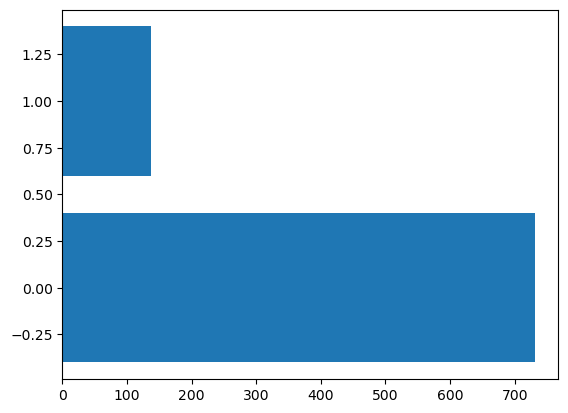

In [29]:
data2 = [12 * 60 + 11, 2 * 60 + 17]

plt.barh(range(len(data2)), data2)

plt.show() 

## Multi-process, Single-thread

In [13]:
from multiprocessing import Pool
from goTokyoMultiProcess import getAreaInfoProcess, testing, getAreaInfoProcessSingleLine

In [14]:
start = timer()
for place in placeAndUrlList[3:]:
    placeSize = len(place[2])
    logger.debug("place: {} len: {}", place[0], placeSize)
    if placeSize > 0:
        # Create pool of workers
        pool = Pool(placeSize)

        # Map pool of workers to process
        pool.starmap(func=getAreaInfoProcessSingleLine, iterable=place[2])

#         logger.debug("Process close")
#         pool.close()
        logger.debug("Process join")
#         pool.join(30)
        pool.wait(30)
        logger.debug("Sleep time")
        time.sleep(1)
    else:
        logger.debug("place: {} less or equal then 0, {}", place[0], placeSize)

end = timer()
logger.debug("Process take time {}", timedelta(seconds=end-start))

2022-12-11 01:38:58.394 | DEBUG    | __main__:<module>:4 - place: 도쿄서부 len: 12
2022-12-11 01:38:59.155 | DEBUG    | goTokyoMultiProcess:getAreaInfoProcessSingleLine:107 - Area crawling process start, areaName: 신주쿠, url: https://www.gotokyo.org/kr/destinations/western-tokyo/shinjuku/index.html
2022-12-11 01:38:59.155 | INFO     | goTokyoMultiProcess:getAreaInfoProcessSingleLine:111 - Setup headless browser options
2022-12-11 01:38:59.155 | DEBUG    | goTokyoMultiProcess:getAreaInfoProcessSingleLine:107 - Area crawling process start, areaName: 시부야, url: https://www.gotokyo.org/kr/destinations/western-tokyo/shibuya/index.html
2022-12-11 01:38:59.155 | INFO     | goTokyoMultiProcess:getAreaInfoProcessSingleLine:111 - Setup headless browser options
2022-12-11 01:38:59.159 | DEBUG    | goTokyoMultiProcess:getAreaInfoProcessSingleLine:107 - Area crawling process start, areaName: 하라주쿠, url: https://www.gotokyo.org/kr/destinations/western-tokyo/harajuku/index.html
2022-12-11 01:38:59.159 | INFO

2022-12-11 01:40:07.697 | DEBUG    | goTokyoMultiProcess:getSlideItems:27 - Slider item list len 1
2022-12-11 01:40:08.075 | DEBUG    | goTokyoMultiProcess:getAreaInfoProcessSingleLine:160 - Crawl slider items result [('쇼핑', [('Hillside Terrace', 'https://www.gotokyo.org/en/spot/547/images/547_0381_1_670x450.jpg', 'https://www.gotokyo.org/kr/spot/547/index.html'), ('다이칸야마의 참신한 패션 공간, 식물과 자연광이 만드는 완전히 아름다운 콜라보레이션을 체감', 'https://www.gotokyo.org/kr/new-and-now/new-and-trending/190624/images/190624_thum_400.jpg', 'https://www.gotokyo.org/kr/new-and-now/new-and-trending/190624/topics.html'), ('다이칸야마 쓰타야 서점 DAIKANYAMA T-SITE', 'https://www.gotokyo.org/_nopub/kr/20191031_065/images/new65_670x450.jpg', 'javascript:void(0);'), ('르라보 재팬', 'https://www.gotokyo.org/_nopub/en/spot/1316/images/1316_1286_1_670x450.jpg', 'javascript:void(0);'), ('헐리우드 랜치 마켓', 'https://www.gotokyo.org/_nopub/kr/spot/1613/images/1320_1_670x450.jpg', 'javascript:void(0);'), ('메종키츠네 다이칸야마', 'https://www.gotokyo.org/_nopub

2022-12-11 01:40:29.153 | DEBUG    | goTokyoMultiProcess:getSlideItems:27 - Slider item list len 6
2022-12-11 01:40:30.040 | INFO     | goTokyoMultiProcess:getAreaInfoProcessSingleLine:152 - Banner removed
2022-12-11 01:40:30.040 | INFO     | goTokyoMultiProcess:getAreaInfoProcessSingleLine:155 - Crawl slider items
2022-12-11 01:40:30.083 | DEBUG    | goTokyoMultiProcess:getSlideItems:27 - Slider item list len 2
2022-12-11 01:40:30.085 | DEBUG    | goTokyoMultiProcess:getSlideItems:27 - Slider item list len 4
2022-12-11 01:40:30.245 | DEBUG    | goTokyoMultiProcess:getSlideItems:27 - Slider item list len 2
2022-12-11 01:40:30.663 | DEBUG    | goTokyoMultiProcess:getSlideItems:27 - Slider item list len 3
2022-12-11 01:40:30.814 | DEBUG    | goTokyoMultiProcess:getSlideItems:27 - Slider item list len 3
2022-12-11 01:40:31.206 | DEBUG    | goTokyoMultiProcess:getSlideItems:27 - Slider item list len 1
2022-12-11 01:40:31.255 | DEBUG    | goTokyoMultiProcess:getAreaInfoProcessSingleLine:160

KeyboardInterrupt: 

In [ ]:
!echo $$